In [1]:

import torch
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
import pandas as pd
import glob

import segmentation_models_pytorch as smp

import lightning as L
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
import torchmetrics as tm

from config import Config
from dataset import *
from utils import DiceCELossSplitter, plot_img_label_pred, AggregateTestingResultsCallback
from transforms import ImageVisualizer
import wandb
import seaborn as sns

import monai
from monai.transforms import *

from tabulate import tabulate
import matplotlib.pyplot as plt
from monai.transforms import *
from transforms import *
from utils import *

seed_everything(99, workers=True)


Seed set to 99


99

In [2]:
# globally set source domains for SVDNA and for dataset preppning
cfg = Config(source_domains = ["Spectralis", "Topcon", "Cirrus"])
cfg.batch_size = 1
cfg.epochs = 150

train_data, val_data, test_data = OCTDatasetPrep(cfg.train_dir,
                                                 source_domains = cfg.source_domains
                                                ).get_datasets(dataset_split=[1, 0], use_official_testset=False)

train_transforms = Compose([
    CustomImageLoader(keys=['img', 'label']), # if SVDNA should not be performed, uncomment this and comment the following two lines
    #SVDNA(keys=['img'], histogram_matching_degree=.5, source_domains=self.source_domains),
    #CustomImageLoader(keys=['label']),
    ConvertLabelMaskToChannel(keys=['label'], target_keys=["masks"]),
    ExpandChannelDim(keys=['img', 'label']),
    ToTensord(keys=['img', 'label', 'masks']),
    #Lambdad(keys=['img', 'label', 'masks'], func = lambda x: 2*(x - x.min()) / (x.max() - x.min()) - 1 ),  # -1 to 1 scaling
    NormalizeToZeroOne(keys=['img', 'label', 'masks']),
    #Resized(keys=["img", "label", 'masks'], mode=["area", "nearest-exact", "nearest-exact"], spatial_size=[512, 1024]),
    #RandZoomd(keys=["img", "label", 'masks'], mode=["area", "nearest-exact", "nearest-exact"], prob=0.3, min_zoom=1, max_zoom=1.5),
    #RandAxisFlipd(keys=["img", "label", 'masks'], prob=0.3),
    #RandAffined(keys=["img", "label", 'masks'], 
    #            prob=0.3, 
    #            shear_range=[(-0.2, 0.2), (0.0, 0.0)], 
    #            translate_range=[(-100, 100), (0, 0)],
    #            rotate_range=[-15, 15],
    #            mode=["bilinear", "nearest", "nearest"], 
    #            padding_mode="zeros"),      
    #Debugging(keys=['img', 'label', 'masks']),
])

train_dataset = MakeDataset(train_data, train_transforms)
train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=7, persistent_workers=True)

Total dataset length:  2408
Training set: 2408
Validation set: 0
Test set: 0


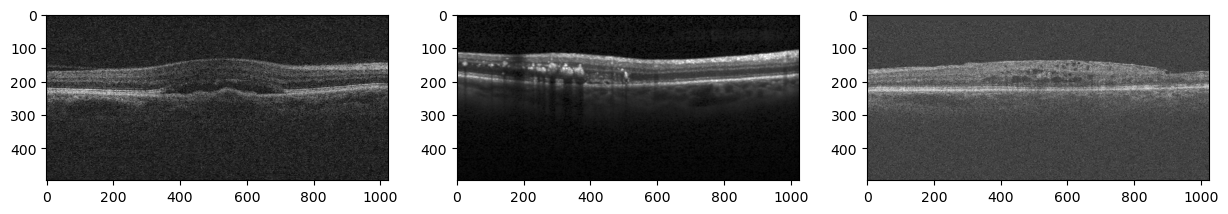

In [ ]:
# randomly sampled 3 images from the training set and put them into subplots next to each other

rand_num = np.random.randint(0, len(train_dataset), 3)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axs):
    sample = train_dataset[rand_num[i]]
    img = sample['img'].squeeze(0)

    # use matplotlib to plot
    ax.imshow(img, cmap='gray')

In [ ]:
import os
import glob
img_folder = "data/Retouch-Preprocessed/train/"

imgs = len(glob.glob(f"{img_folder}/*/image/*.png", recursive=True))
labels = len(glob.glob(f"{img_folder}/*/label_image/*.png", recursive=True))

print(f"Number of images: {imgs}, Number of labels: {labels}")

Number of images: 6936, Number of labels: 3385


In [ ]:

# go through the entire training dataset, always ignoring channel 0, and collect some statistics.
# the image masks have the properties that the pixels are either 0 or 1 and pixels == 1 are much less than pixels == 0
# 1. how many images have more than 1% of pixels == 1 in the masks channels 1, 2 or 3
# 2. in the channels 1, 2 or 3, what is the average percentage of pixels == 1
# 3. what is the average percentage of pixels == 1 in the entire mask
# 4. all positive ( == 1) pixels in the first channel divided by all positive pixels in channels 1, 2 and 3.

@torch.no_grad()
def calculate_statistics(loader):
    total_images = 0
    images_with_more_than_1_percent = 0
    total_percentage_in_channels_123 = 0
    total_percentage_in_all_channels = 0
    total_positive_in_channel_0 = 0
    total_positive_in_channels_123 = 0

    for sample in loader:
        images, masks = sample["img"], sample["masks"]
        total_images += images.shape[0]

        images = images.cpu()
        masks = masks.cpu()

        # Calculate the percentage of positive pixels in each mask
        percentages = masks.mean(dim=[2, 3])  # Shape: (batch_size, num_channels)

        # Calculate the number of images with more than 1% of positive pixels in channels 1, 2, or 3
        images_with_more_than_1_percent += (percentages[:, 1:] > 0.01).any(dim=1).sum().item()

        # Calculate the average percentage of positive pixels in channels 1, 2, and 3
        total_percentage_in_channels_123 += percentages[:, 1:].mean().item()

        # Calculate the average percentage of positive pixels in all channels
        total_percentage_in_all_channels += percentages.mean().item()

        # Calculate the total number of positive pixels in channel 1 and channels 1, 2, and 3
        total_positive_in_channel_0 += masks[:, 0].sum().item()
        total_positive_in_channels_123 += masks[:, 1:].sum().item()

    # Calculate the average percentages
    average_percentage_in_channels_123 = total_percentage_in_channels_123 / total_images
    average_percentage_in_all_channels = total_percentage_in_all_channels / total_images

    # Calculate the ratio of positive pixels in channel 1 to positive pixels in channels 1, 2, and 3
    ratio = total_positive_in_channel_0 / total_positive_in_channels_123

    return {
        "Total images": total_images,
        "Images with more than 1% of positive pixels in channels 1, 2, or 3": images_with_more_than_1_percent,
        "Average percentage of positive pixels in channels 1, 2, or 3": average_percentage_in_channels_123,
        "Average percentage of positive pixels in all channels": average_percentage_in_all_channels,
        "Ratio of positive pixels in channel 1 to positive pixels in channels 1, 2, and 3": ratio,
    }

statistics = calculate_statistics(train_loader)
for key, value in statistics.items():
    print(f"{key}: {value}")

Total images: 2408
Images with more than 1% of positive pixels in channels 1, 2, or 3: 1216
Average percentage of positive pixels in channels 1, 2, or 3: 0.0064524040509944145
Average percentage of positive pixels in all channels: 0.24999999931929912
Ratio of positive pixels in channel 1 to positive pixels in channels 1, 2, and 3: 50.66033166647701
